![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2F02+-+Vertex+AI+AutoML&dt=02b+-+Vertex+AI+-+AutoML+with+clients+%28code%29.ipynb)

# 02b - Vertex AI - AutoML with clients (code)

Use the Vertex AI Python Client to recreate the no-code approach of (02a) with code (Python).  This builds a custom model with AutoML and deploys it to an Endpoint for predictions and explanations. 

### Prerequisites:
-  01 - BigQuery - Table Data Source

### Resources:
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
-  [AutoML Tabular Training Job With Python Client](https://cloud.google.com/vertex-ai/docs/training/automl-api#aiplatform_create_training_pipeline_tabular_classification_sample-python)
-  [Interpreting Explanations](https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular)

<p align="center">
  <img alt="Conceptual Flow" src="../architectures/overview/02_overview.png" width="25%">
</p>

### Conceptual Flow & Workflow

#### Overview
-  Use Python client  google.cloud.aiplatform for Vertex AI
    -   Create a dataset
        -  aiplatform.TabularDataset
        -  Link BigQuery table
    -   Train Model with AutoML
        -  aiplatform.AutoMLTabularTrainingJob
    -   Evaluate 
        -  Review the model in GCP Console > Vertex AI > Models
    -   Deploy to Endpoint
        -  Endpoint = aiplatform.Endpoint
        -  Endpoint.deploy
    -   Online Predictions
        -  Endpoint.predict
    -   Explanations
        -  Endpoint.explain
    -   Batch Prediction Job
        -  aiplatform.BatchPredictionJob
        

<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/02b_arch.png" width="80%">
</p>
<p align="center">
  <img alt="Workflow" src="../architectures/slides/02b_console.png" width="80%">
</p>


---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'avid-streamer-396319'

In [3]:
REGION = 'us-central1'
DATANAME = 'fraud'
NOTEBOOK = '02b'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [4]:
from google.cloud import aiplatform
from datetime import datetime

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [5]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

parameters:

In [7]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
DIR = f"temp/{NOTEBOOK}"

environment:

In [8]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Create Dataset (link to BigQuery table)

In [9]:
dataset = aiplatform.TabularDataset.create(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}', 
    bq_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    labels = {'notebook':f'{NOTEBOOK}'}
)

---
## Train Model with AutoML

In [11]:
#remove splits, target, transaction_id columns
column_specs = list(set(dataset.column_names) - set(VAR_OMIT.split()) - set([VAR_TARGET, 'splits']))
column_specs

['V6',
 'V25',
 'V28',
 'V27',
 'V9',
 'V8',
 'V17',
 'V1',
 'V14',
 'V18',
 'V21',
 'V7',
 'V16',
 'V3',
 'V22',
 'Time',
 'V15',
 'V12',
 'V19',
 'Amount',
 'V11',
 'V13',
 'V23',
 'V20',
 'V5',
 'V4',
 'V2',
 'V10',
 'V24',
 'V26']

In [12]:
#create dict
column_specs = dict.fromkeys(column_specs, 'auto')
column_specs

{'V6': 'auto',
 'V25': 'auto',
 'V28': 'auto',
 'V27': 'auto',
 'V9': 'auto',
 'V8': 'auto',
 'V17': 'auto',
 'V1': 'auto',
 'V14': 'auto',
 'V18': 'auto',
 'V21': 'auto',
 'V7': 'auto',
 'V16': 'auto',
 'V3': 'auto',
 'V22': 'auto',
 'Time': 'auto',
 'V15': 'auto',
 'V12': 'auto',
 'V19': 'auto',
 'Amount': 'auto',
 'V11': 'auto',
 'V13': 'auto',
 'V23': 'auto',
 'V20': 'auto',
 'V5': 'auto',
 'V4': 'auto',
 'V2': 'auto',
 'V10': 'auto',
 'V24': 'auto',
 'V26': 'auto'}

**Define a Job wit ai.platform:**
- Consider Weighting
- Model Type
- Optimization Objective

https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLTabularTrainingJob

In [14]:
tabular_classification_job = aiplatform.AutoMLTabularTrainingJob(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    optimization_prediction_type = 'classification',
    optimization_objective = 'maximize-au-prc',
    column_specs = column_specs,
    labels = {'notebook':f'{NOTEBOOK}'}
)

In [15]:
model = tabular_classification_job.run(
    dataset = dataset,
    target_column = VAR_TARGET,
    predefined_split_column_name = 'splits',
    #    training_fraction_split = 0.8,
    #    validation_fraction_split = 0.1,
    #    test_fraction_split = 0.1,
    budget_milli_node_hours = 1000,#1h
    model_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    disable_early_stopping = False,
    model_labels = {'notebook':f'{NOTEBOOK}'}
)

---
## Evaluation
While the model above was trained using AutoML with the API, it is still possible to review the evaluation metrics directly in the Google Cloud Console.  Just visit the Models section of Vertex AI service and select the model and it will present the evaluation metrics with many helpful visuals.

It is also possible to retrieve the evaluation metrics for you model using the API.  This section shows how to use the API.


For more information review [this page](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models).

**Setup a model client for the model create by this notebook:**

In [16]:
model.resource_name

'projects/114910882374/locations/us-central1/models/6243754899209715712'

In [17]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

Retrives the aggregate model evalution metrics for the model as a whole.  First, use `.list_model_evaluations` to retrieve the evaluation id, then use `.get_model_evaluation` for the evaluation id:

In [18]:
evaluations = model_client.list_model_evaluations(parent = model.resource_name)
evals = iter(evaluations)
eval_id = next(evals).name #get first evaluation ID
geteval = model_client.get_model_evaluation(name = eval_id)

Review several of the metrics include in the evaluation.  Also, compare these to the results in the console view.

In [19]:
geteval.metrics['auPrc']

0.99948853

In [20]:
for i in range(len(geteval.metrics['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', geteval.metrics['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', geteval.metrics['confusionMatrix']['rows'][i])

True Label =  0  has Predicted labels =  [28266.0, 2.0]
True Label =  1  has Predicted labels =  [12.0, 30.0]


For models with labels you can retrieve the evaluation metrics for each slice of the model:

In [21]:
slices = model_client.list_model_evaluation_slices(parent = eval_id)

In [22]:
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  1 has auPrc =  0.73670185
Label =  0 has auPrc =  0.9996085


---
## Endpoint and Deployment

In [23]:
endpoint = aiplatform.Endpoint.create(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    labels = {'notebook':f'{NOTEBOOK}'}
)

In [24]:
endpoint.deploy(
    model = model,
    deployed_model_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,# minimum number of instances of the deployed model that should be maintained and ready to serve requests.
    max_replica_count = 1
)

---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [25]:
pred = bigquery.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()

In [26]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,119592,2.139741,0.245651,-2.654856,0.178287,1.336991,-0.724664,0.906032,-0.436125,-0.528015,...,-0.216033,0.345316,0.747103,0.700184,-0.123739,-0.099989,0.0,0,c1908dfc-b9fe-4329-947f-ce1d8b705ac3,TEST
1,129420,-0.539919,1.273124,0.987345,2.207887,0.827857,1.099094,0.154173,0.567619,-1.140350,...,-0.039536,0.308004,-1.128751,-0.291094,-0.157021,-0.031830,0.0,0,f97a4ab2-dfa3-4745-bfb5-19796e93f0c1,TEST
2,75176,1.235603,0.041383,0.675286,0.836279,-0.675016,-0.657342,-0.154209,-0.067491,0.602617,...,0.088164,0.396205,0.324557,0.182930,-0.017115,0.014979,0.0,0,41e4cf07-f271-45fe-babe-88af8c4a9d69,TEST
3,167575,1.808792,-0.632766,-0.547739,0.142396,0.222408,1.824899,-1.068149,0.721798,0.914282,...,0.262650,-1.741824,-0.606627,0.493312,0.049780,-0.075780,0.0,0,ec304a05-c031-43ab-a903-461cd394de99,TEST


In [27]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]
newob

{'Time': 119592,
 'V1': 2.13974143206254,
 'V2': 0.24565051250681602,
 'V3': -2.65485572436196,
 'V4': 0.178286715236351,
 'V5': 1.33699090034429,
 'V6': -0.7246639980638521,
 'V7': 0.906032324072013,
 'V8': -0.436124936675182,
 'V9': -0.52801525053786,
 'V10': 0.4040441255568761,
 'V11': 0.671436482416233,
 'V12': 1.09175002324314,
 'V13': 0.645989341587513,
 'V14': 0.83703762258463,
 'V15': -0.939859907683146,
 'V16': -0.5514662327417371,
 'V17': -0.5359086170901329,
 'V18': -0.20255223674504802,
 'V19': 0.39832598192236995,
 'V20': -0.16098841557650598,
 'V21': 0.29668077170407603,
 'V22': 1.03628515668158,
 'V23': -0.21603343812676803,
 'V24': 0.345316055806933,
 'V25': 0.7471034235245171,
 'V26': 0.700184057817132,
 'V27': -0.12373914080650501,
 'V28': -0.0999890044385541,
 'Amount': 0.0}

Need to understand the format of variables that the predictions expect.  AutoML may convert the type of some variables. The following cells retrieve the model from the endpoint and its schemata:

In [28]:
#AUtoMl treats time as string
newob['Time'] = str(newob['Time'])

In [29]:
#create variables: jsondict
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

### Get Predictions: Python Client

In [30]:
prediction = endpoint.predict(instances=instances, parameters=parameters)

In [31]:
prediction

Prediction(predictions=[{'classes': ['0', '1'], 'scores': [0.99991774559021, 8.227969374274835e-05]}], deployed_model_id='4098145918535073792', model_version_id='1', model_resource_name='projects/114910882374/locations/us-central1/models/6243754899209715712', explanations=None)

In [32]:
prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'0'

### Get Predictions: REST

In [33]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

In [34]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "scores": [
        0.99991774559021,
        8.227969374274835e-05
      ],
      "classes": [
        "0",
        "1"
      ]
    }
  ],
  "deployedModelId": "4098145918535073792",
  "model": "projects/114910882374/locations/us-central1/models/6243754899209715712",
  "modelDisplayName": "02b_fraud_20230824144322",
  "modelVersionId": "1"
}


### Get Predictions: gcloud (CLI)

In [35]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['0', '1'], 'scores': [0.99991774559021, 8.227969374274835e-05]}]


---
## Explanations
Interpretation Guide
- https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular

In [36]:
explanation = endpoint.explain(instances=instances, parameters=parameters)

In [37]:
explanation.predictions

[{'scores': [0.99991774559021, 8.227969374274835e-05], 'classes': ['0', '1']}]

In [38]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.9925267100334167
instance output 0.99991774559021
output_index [0]
output display value 0
approximation error 0.017179790225849118


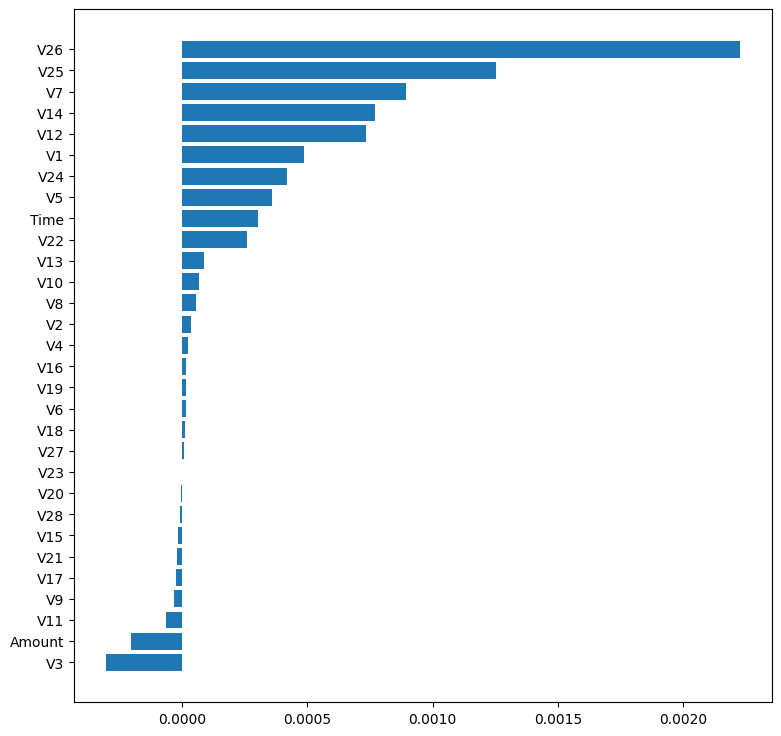

In [39]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

---
## Batch Predictions: BigQuery Source to BigQuery Destination, with Explanations

In [40]:
batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    model_name = model.name,
    instances_format = "bigquery",
    predictions_format = "bigquery",
    bigquery_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation = True,
    labels = {'notebook':f'{NOTEBOOK}'}
)

---
## Remove Resources
see notebook "99 - Cleanup"